# Set up analysis environment

In [2]:
using Pkg
Pkg.activate("..");

 Activating environment at `~/code/algorithmwatch-instagram/Project.toml`


In [3]:
Pkg.instantiate()
using CSV, JSON
using DataFrames
using Dates, CategoricalArrays
using Statistics, GLM
using VegaLite

# Load posts and donations
Towards a Monitoring of Instagram (TAMI) is a controlled experiment that aims at shedding light on how items are prioritized by Instagram‚Äôs newsfeed algorithm, focusing on political parties in the Netherlands. Posts of Dutch politicians (all members of parliament and the top politician of each party) and political parties were monitored. A set of donors was recruited. Donors share their Instagram feed at hourly intervals. **We are interested in understanding what posts of the politians are encountered by the donors in their feed.**  

We organize the analysis around potential encounters of posts of monitored politicians by donors at hourly intervals. Only the first 7 days after post creation are considered. For each of potential encounter, we store the following dynamic properties at hourly intervals: the number of likes, the number of comments, and the presence of an encounter. We use information from posts to model the probability of an encounter given a certain post. To this end, we prepare a representation of posts with  static properties that can explain the probability of an encounter. It is based on results from the Google Vision API (safe search, label annotations), hashtags from the post text, and the number of followers of the politician‚Äôs account.

### Data last updated Feb 5

## Posts

In [4]:
posts = CSV.File("../data/posts_with_topics.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;

print("Total posts in the sample (incl. video posts)")
length(unique(posts[!, :post_short_code]))

Total posts in the sample (incl. video posts)

8603

In [5]:
transform!(posts, :poster_username => categorical => :poster_username)
transform!(posts, [:image_adult, :image_medical, :image_racy, :image_spoof, :image_violence] .=> categorical);

For some posts we can't analyze the caption (i.e. it is empty), and sometimes we cannot analyze the image tags (e.g. for videos). These are removed from the analysis:

In [6]:
@show count(ismissing.(posts.ig_media_caption));

transform!(posts, :image_labels => ByRow(x -> length(JSON.parse(x))) => :num_image_labels);
@show count(posts.num_image_labels .== 0);

dropmissing!(posts);
posts = posts[posts.post_created .>= DateTime(2020, 1, 1),:];

print("Total posts in the sample (excl. video posts)")
length(unique(posts[!, :post_short_code]))

count(ismissing.(posts.ig_media_caption)) = 206
count(posts.num_image_labels .== 0) = 1711
Total posts in the sample (excl. video posts)

6716

Now we show the number of posts created by the politicians over time. There could be a ramp-up towards the elections, but many elements need to be considered. In particular: 
- we added new accounts of politicians in November 2020
- our scraper might have missed some posts (might be the cause of the October drop)
- some politicians switched their profiles to "private" over the course of the experiment.

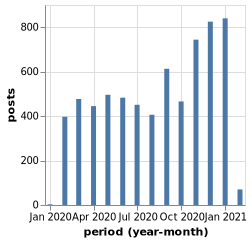

In [7]:
period_posts = combine(
    groupby(transform(unique(posts[!, [:post_short_code, :post_created]]), :post_created => ByRow(t -> round(t, Dates.Day)) => :period), [:period]),
    nrow => :num_posts)

period_posts |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"sum(num_posts)", axis={title="posts"}},
)

## Topics

In order to find out whether Instagram's algorithm favored some content over the rest, we divided the posts into topics.

**Topics are defined automatically and change with new data**. We use a latent Dirichlet allocation (LDA) to divide the posts into topics. LDA is a commonly-used algorithm that detects topics in documents based on the distribution of words, and allocates a "topic score" to each, so that a document does not have to be linked to just one topic (e.g. a post showing a face and a cat could be classified as 50% topic "faces" and 50% topic "pets").

We divide all posts into twice 8 topics (the number 8 was chosen arbitrarily), first by caption, then by image labels.

### Caption topics

The words in the topics were organized into eight topics. A label was constructed for each topic by interpreting the top words in each topic. Here are posts that score high on an individual caption topic:

In [8]:
gdf = groupby(stack(posts, names(posts, r"cap_top\d+")), :variable);

Based on these posts, and the top words in `topics_caption.csv` the following interpretion was made. In the figure that show the proportion of the topics over time, we can see that the election topics grows in the lasts months:

In [9]:
topics_caption = CSV.File("../data/topics_caption.csv")|> DataFrame
first(topics_caption,10)

10√ó8 DataFrame
 Row ‚îÇ top1       top2       top3                 top4    top5           top6         top7    top8       
     ‚îÇ String     String     String               String  String         String       String  String     
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ fvd        nederland  via                  corona  and            even         of      mijn
   2 ‚îÇ meer       meer       uur                  weer    of             nederland    ons     jaar
   3 ‚îÇ nederland  mensen     link                 veel    to             mijn         dan     was
   4 ‚îÇ geen       worden     live                 mensen  i              mooi         jij     nog
   5 ‚îÇ kabinet    moet       bio                  kamer   for            jaar         wil     ze
   6 ‚îÇ nu         door       kortelijnmetmartijn  zorg    this           weer         nog     door
   7 ‚îÇ door       wij        vanavond             zo      you            door         bio     heb
   8 ‚îÇ ons        moeten     zee                  alle    piratenpartij  oranje       link    me
   9 ‚îÇ corona     kunnen     gast                 tweede  love           amsterdam    hebben  groenlinks
  10 ‚îÇ worden     hun        strand               nu      be             tweedekamer  kunnen  al

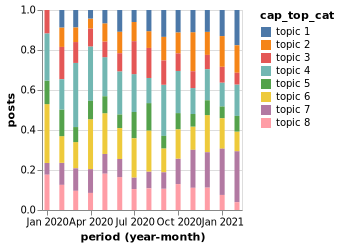

In [10]:
posts.cap_top_cat = recode(string.(posts.cap_top_cat),
    "1" => "topic 1",
    "2" => "topic 2",
    "3" => "topic 3",
    "4" => "topic 4",
    "5" => "topic 5",
    "6" => "topic 6",
    "7" => "topic 7",
    "8" => "topic 8",
);

period_caption = combine(
    groupby(transform(posts, :post_created => ByRow(yearmonth) => :period), [:period, :cap_top_cat]),
    nrow => :count)

period_caption |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"count", axis={title="posts"}, stack=:normalize},
    color={"cap_top_cat:n"})

### Image topics
Images were analyzed with the Google Vision API, and the resulting image tags were organized into eight topics. The post the highest score per topic are listed below:

In [11]:
gdf = groupby(stack(posts, names(posts, r"im_top\d+")), :variable);
#select(
#    combine(df -> first(sort(df, :value, rev=true), 3), gdf),
#    :im_top_cat, :post_short_code => ByRow(x -> string("http://instagram.com/p/", x)))

Based on these posts, and the top labels in `topics_image.csv` the following interpretation of the image topics was made. Some categories are not very clear and some concepts (such as electronics) can easily move from one topic to another when we re-run the LDA topic modelling.

In [12]:
topics_image = CSV.File("../data/topics_image.csv")|> DataFrame
first(topics_image,10)

10√ó8 DataFrame
 Row ‚îÇ top1           top2             top3                 top4         top5             top6               top7               top8                
     ‚îÇ String         String           String               String       String           String             String             String              
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ font           architecture     event                event        art              food               face               sky
   2 ‚îÇ text           building         job                  photography  illustration     vehicle            forehead           tree
   3 ‚îÇ line           interior design  white-collar worker  fun          publication      cuisine            head               plant
   4 ‚îÇ advertising    room             businessperson       outerwear    font             dish               chin               cloud
   5 ‚îÇ brand          furniture        employment           smile        photography      car                smile              grass
   6 ‚îÇ screenshot     table            public speaking      people       black-and-white  ingredient         hair               natural landscape
   7 ‚îÇ photo caption  city             conversation         tourism      visual arts      motor vehicle      nose               water
   8 ‚îÇ graphics       house            suit                 suit         design           transport          facial expression  natural environment
   9 ‚îÇ document       sky              spokesperson         team         hand             mode of transport  photography        nature
  10 ‚îÇ logo           lighting         official             vacation     text             meal               eyebrow            leaf

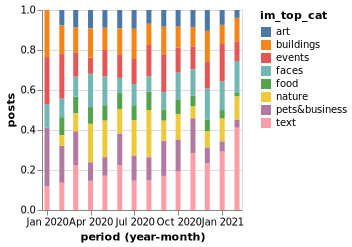

In [13]:
posts.im_top_cat = recode(string.(posts.im_top_cat), 
    "1" => "text",
    "2" => "buildings",
    "3" => "pets&business",
    "4" => "events",
    "5" => "art",
    "6" => "food",
    "7" => "faces",
    "8" => "nature",
);

period_image = combine(
    groupby(transform(posts, :post_created => ByRow(yearmonth) => :period), [:period, :im_top_cat]),
    nrow => :count)

period_image |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonth"}, 
    y={"count", axis={title="posts"}, stack=:normalize},
    color={"im_top_cat:n"})

## Donations

Next we load the donations, and display the number of donations over time. The number of donations varied wildly, with a peak in November when the call-to-action was issued.

In [14]:
donations = CSV.File("../data/donations.csv", dateformat="yyyy-mm-dd HH:MM:SS") |> DataFrame;

donations.post_DOW = categorical(map(Dates.dayname, donations.post_created), levels=Dates.dayname.(1:7));
donations.post_HOD = categorical(map(x -> Dates.value(Dates.Hour(x)), donations.post_created));
donations.post_age = (donations.donation_created - donations.post_created) / convert(Dates.Millisecond, Dates.Hour(1));

donations.likes_cat = cut(donations.likes_count, [0, 5, 10, 100, 1000], extend=true);
donations.comments_cat = cut(donations.comments_count, 5);
donations.post_age_cat = cut(donations.post_age, [1, 3, 24], extend=true);

@show(nrow(donations))

nrow(donations) = 36930


36930

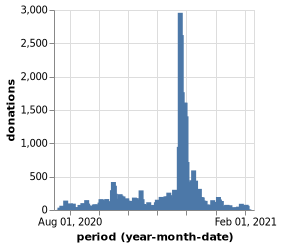

In [15]:
period_donations = combine(
    groupby(transform(donations, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), :period),
    nrow => :num_donations)

period_donations |> @vlplot(:bar, 
    x={"period:t", timeUnit="yearmonthdate"}, 
    y={"sum(num_donations)", axis={title="donations"}},
)

In [16]:
df = innerjoin(select(donations, Not(:post_created)), posts, on=:post_id);

## RQ1: What posts are overrepresented in the encounters?

To answer this question, we need to describe what posts of Dutch politicians on Instagram are overrepresented in general. This might be due to popularity of the post, or due to biases in Instagram‚Äôs recommendations. We are interested in topics, derived from words in the caption and from Google Vision API labels for the post‚Äôs images.

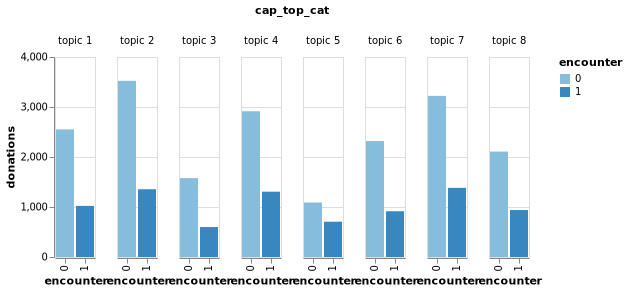

In [17]:
combine(groupby(df, [:cap_top_cat, :encounter]), nrow => :donations) |>
@vlplot(
    :bar,
    column = "cap_top_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = "donations"
)

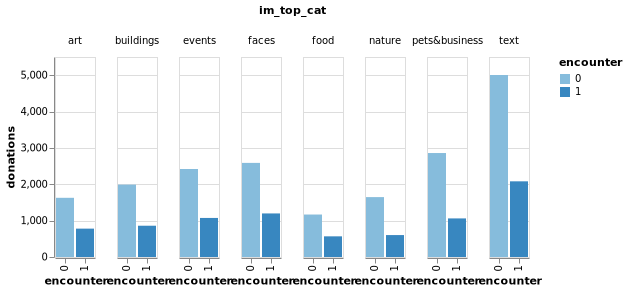

In [18]:
combine(groupby(df, [:im_top_cat, :encounter]), nrow => :donations) |>
@vlplot(
    :bar,
    column = "im_top_cat:o",
    color = "encounter:o",
    x = "encounter:o",
    y = :donations
)

## RQ2: What posts are overrepresented given their popularity? 
Since overrepresentation is likely to driven by popularity, we analyse what types of posts are overrepresented if we **correct for effects of post popularity** and the timing of a post (time of the day and day of the week). Remaining variations in post popularity can indicate biases in Instagram‚Äôs recommendations. The biases might be limited to the population of donors.

In [19]:
baseline_formula = @formula(encounter ~ 1 
    + log1p(post_age) + log1p(likes_count) + log1p(comments_count) + log1p(follows)
    + post_age_cat + likes_cat + comments_cat
    + post_DOW + post_HOD
    );
baseline_model = glm(baseline_formula, df, Binomial(), LogitLink());
df.pred_popularity = predict(baseline_model, df);

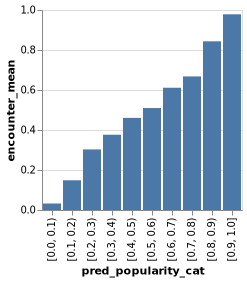

In [20]:
df.pred_popularity_cat = cut(df.pred_popularity, 0:.1:1, extend=true);
combine(groupby(df, :pred_popularity_cat), :encounter=>mean) |> 
    @vlplot(:bar, x="pred_popularity_cat:o", y=:encounter_mean)

This figure shows the encounter frequency is well predicted with the logisitic regression model for popularity. Thus, a large part of the observed encounters can be explained by the presence of competing posts (i.e. time of day or day of week effects), and by the popularity of a post in relation to its age (through post age, likes and comments). We use this model as a popularity factor, to analyse how much properties of the post content *additionally* changes the probability of encountering a post.

In [21]:
odds(p) = p / (1-p);
logit(p) = log(odds(p));

f2 = @formula(
    encounter ~ 1
        + logit(pred_popularity) # Here we re-use the prediction from the popularity model.
        + (im_top2 + im_top3 + im_top4 + im_top5 + im_top6 + im_top7 + im_top8)
        + (cap_top2 + cap_top3 + cap_top4 + cap_top5 + cap_top6 + cap_top7 + cap_top8)
        + image_adult_categorical + image_medical_categorical + image_racy_categorical + image_spoof_categorical + image_violence_categorical
    );

m2 = glm(f2, df, Binomial(), LogitLink());
df.prediction_RQ2 = predict(m2, df);

Now we can compare the predictions of the baseline popularity model, and the model that uses topic information in addition to the popularity factors. Differences between the predictions are due to topics. If a topic results in an increased chance of an encouter, we call this a positive bias. To compute the bias, we convert the predictions of both models to log-odds using the logit transform, and compute the difference.

In [22]:
df.bias = logit.(df.prediction_RQ2) - logit.(df.pred_popularity);

Now we can analyze the bias per caption topic.

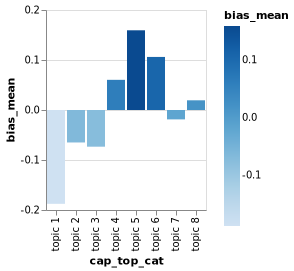

In [23]:
combine(groupby(df, :cap_top_cat), :bias=>mean) |> 
    @vlplot(:bar, x="cap_top_cat:o", y=:bias_mean, color=:bias_mean)

Images with the topics `faces` are more likely to reach the donor's feed, while `text` are less likely to reach the donor's feed.

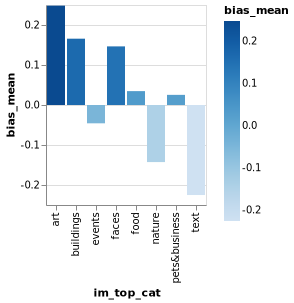

In [24]:
combine(groupby(df, :im_top_cat), :bias=>mean) |> 
    @vlplot(:bar, x="im_top_cat:o", y=:bias_mean, color=:bias_mean)

 Note that this bias might not generalize to other content creators than Dutch politicians, and might not generalize to other users than the donors that participated in this experiment.

## RQ3: Is the overrepresentation the same in all subgroups? 

Do the results hold robustly in sub groups? If so, they are more likely to generalize to a wider population. Here we split the data in months, and analyze if the bias is indeed higher for encountered posts than non-encountered posts in each month.

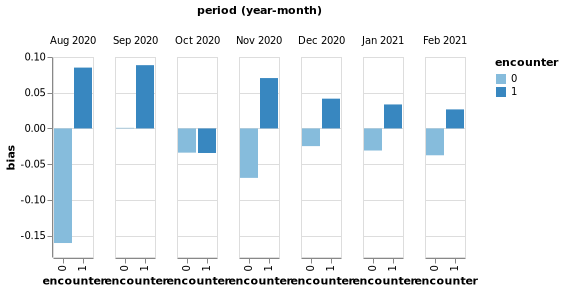

In [25]:
period_bias = combine(
    groupby(transform(df, :post_created => ByRow(t -> round(t, Dates.Month)) => :period), [:period, :encounter]),
    :bias => mean)

period_bias |> @vlplot(:bar, 
    column={"period:o", timeUnit="yearmonth"}, 
    x = "encounter:o",
    y = {"bias_mean", axis={title="bias"}},
    color = "encounter:o",
)

Within each month, a lower bias is observed for non-encounters than encounters. Thus the bias is robust over different months. Note though that the bias varies strongly from month to month. Since the bias is a function of caption and image topics, this suggests that the *content* has changed from month to month.

## RQ4: Who benefit from these discrepancies? 

Finally, we can estimate per politician how much their posts were benefitting from a consistent algorithm bias of Instagram‚Äôs recommendations. Note that this bias can be caused by personalisation; if the donors are of a particular political affiliation they might be presented more with content in line with their views.

In [26]:
parties = CSV.File("../data/parties.csv") |> DataFrame;
rename!(parties, Symbol("IG username") => :ig_username, Symbol("Full name") => :name);
parties = dropmissing(parties[!,[:party, :ig_username, :name]]);
parties.ig_username = categorical(parties.ig_username);
parties.party = categorical(parties.party);

In [27]:
post_bias = combine(groupby(df, [:post_id, :poster_username]), :bias => mean => :bias)
post_bias = innerjoin(post_bias, parties, on=:poster_username => :ig_username)

poster_bias = combine(groupby(post_bias, [:poster_username, :party]), 
    nrow => :num_encounterable_posts, 
    :bias .=> mean)

poster_bias.benefit = poster_bias.bias_mean;
poster_bias = sort(poster_bias, :benefit, rev=true)
first(poster_bias[poster_bias.num_encounterable_posts .> 5,:], 5)

5√ó5 DataFrame
 Row ‚îÇ poster_username  party  num_encounterable_posts  bias_mean  benefit  
     ‚îÇ Categorical‚Ä¶     Cat‚Ä¶   Int64                    Float64    Float64  
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ klaasdijkhoff    VVD                          6   0.315399  0.315399
   2 ‚îÇ cdavandaag       CDA                          6   0.196818  0.196818
   3 ‚îÇ judith_tielen    VVD                         22   0.180161  0.180161
   4 ‚îÇ koerhuisdaniel   VVD                          8   0.167648  0.167648
   5 ‚îÇ michelrogcda     CDA                         18   0.15987   0.15987

# Appendix

#### Image topic 1

![](topic1.jpg)

#### Image topic 2

![](topic2.jpg)

#### Image topic 3

![](topic3.jpg)

#### Image topic 4

![](topic4.jpg)

#### Image topic 5

![](topic5.jpg)

#### Image topic 6

![](topic6.jpg)

#### Image topic 7

![](topic7.jpg)

#### Image topic 8

![](topic8.jpg)

#### Caption topic 1

In [28]:
first(select(unique(sort(posts, :cap_top1, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

10√ó2 DataFrame
 Row ‚îÇ poster_username   ig_media_caption                  
     ‚îÇ Categorical‚Ä¶      String                            
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ thierry_baudet    Dit bericht komt zojuist binnen.‚Ä¶
   2 ‚îÇ remcovvd          Sinds 12 maart weer terug in de ‚Ä¶
   3 ‚îÇ thierry_baudet    We gaan het HELE LAND door met o‚Ä¶
   4 ‚îÇ geertwilders      Rutte: geen handen schudden!\n\n‚Ä¶
   5 ‚îÇ geertwilders      Ons land, onze cultuur, onze ide‚Ä¶
   6 ‚îÇ geertwilders      Merci #KLM !!
   7 ‚îÇ suzannekroger_gl  Zo dan maar. #treinleven #OV #co‚Ä¶
   8 ‚îÇ suzannekroger_gl  Interview in #Corona tijd over k‚Ä¶
   9 ‚îÇ matthijssienot    Schone energie vraagt om grote i‚Ä¶
  10 ‚îÇ stoffer.chris     Vandaag in debat over #steunpakk‚Ä¶

#### Caption topic 3

In [29]:
first(select(unique(sort(posts, :cap_top3, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

10√ó2 DataFrame
 Row ‚îÇ poster_username     ig_media_caption                  
     ‚îÇ Categorical‚Ä¶        String                            
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ lodewijkasscher     #maandagochtend #mood #louvre
   2 ‚îÇ thierry_baudet      We gaan richting TOTAL NPO INDEP‚Ä¶
   3 ‚îÇ jobavandenberg      Gisteren bij #BNR in #Amsterdam ‚Ä¶
   4 ‚îÇ vandijk_gijs        Het is zover. #Lente #Texel
   5 ‚îÇ klaasdijkhoff       Mijn √ºberprofessionele thuisstud‚Ä¶
   6 ‚îÇ remcovvd            In @guggenheim
   7 ‚îÇ remcovvd            Uitnodiging.. meepraten met de #‚Ä¶
   8 ‚îÇ verabergkamp        #berenjacht #beervoorhetraam #fu‚Ä¶
   9 ‚îÇ haykeveldman        Den Haag vandaag
  10 ‚îÇ stevenvanweyenberg  We zijn begonnen! #D66congres @d‚Ä¶

#### Caption topic 4

In [30]:
first(select(unique(sort(posts, :cap_top4, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

10√ó2 DataFrame
 Row ‚îÇ poster_username   ig_media_caption                  
     ‚îÇ Categorical‚Ä¶      String                            
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ lodewijkasscher   Onder de indruk van de verhalen ‚Ä¶
   2 ‚îÇ thierry_baudet    We stijgen keihard door! Dank aa‚Ä¶
   3 ‚îÇ bentebecker       Vanochtend ben ik voor heel even‚Ä¶
   4 ‚îÇ sandra_beckerman  Niet alle entiteiten waarderen d‚Ä¶
   5 ‚îÇ adiertens         Voor de briefing van het RIVM. S‚Ä¶
   6 ‚îÇ klaasdijkhoff     Hallmark speelt open kaart...
   7 ‚îÇ remcovvd          #Thuiswerken is ook bellen vanui‚Ä¶
   8 ‚îÇ remcovvd          Doen. Wees verstandig! #corona
   9 ‚îÇ niels_vdberge     Vandaag in het wit voor alle hel‚Ä¶
  10 ‚îÇ niels_vdberge     Gisteren mocht ik voor even in d‚Ä¶

#### Caption topic 5

In [31]:
first(select(unique(sort(posts, :cap_top5, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

10√ó2 DataFrame
 Row ‚îÇ poster_username  ig_media_caption                  
     ‚îÇ Categorical‚Ä¶     String                            
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ mustafaamhaouch  üèÉüèΩ\u200d‚ôÇÔ∏èüá≤üá¶ #sportyspice
   2 ‚îÇ thierry_baudet   The last supper. Scrovegni Chape‚Ä¶
   3 ‚îÇ thierry_baudet   #friends #love
   4 ‚îÇ thierry_baudet   Prachtfoto!\n\nCredits: @lonneke‚Ä¶
   5 ‚îÇ klaasdijkhoff    Bij de mondkapper... Thanks @mar‚Ä¶
   6 ‚îÇ klaasdijkhoff    #Applausvoordezorg üëèüèº
   7 ‚îÇ remcovvd         Kip met knoflook on the #bbq üî•#‚Ä¶
   8 ‚îÇ remcovvd         Een #Hercules #plane #spotting #‚Ä¶
   9 ‚îÇ remcovvd         How to make your puber #child #h‚Ä¶
  10 ‚îÇ remcovvd         #Shoe #fun at ##Nike #store

#### Caption topic 6

In [32]:
first(select(unique(sort(posts, :cap_top6, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

10√ó2 DataFrame
 Row ‚îÇ poster_username   ig_media_caption                  
     ‚îÇ Categorical‚Ä¶      String                            
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ thierry_baudet    Mijn lieve papa! @baudetmarcel
   2 ‚îÇ thierry_baudet    Lente. Thuis.
   3 ‚îÇ sandra_beckerman  Ook even tijd voor de cruciale b‚Ä¶
   4 ‚îÇ salimabelhaj      Avondje kaarten thuis. Met wel h‚Ä¶
   5 ‚îÇ jobavandenberg    Even naar buiten voor korte wand‚Ä¶
   6 ‚îÇ remcovvd          En een burgertje op de #bbq üçî w‚Ä¶
   7 ‚îÇ remcovvd          Rondje Batouwse klompenpad #walk‚Ä¶
   8 ‚îÇ remcovvd          Paardjes kijken #rondje #wandele‚Ä¶
   9 ‚îÇ remcovvd          Klompenpad gewandeld, vlakbij hu‚Ä¶
  10 ‚îÇ remcovvd          Living in the #betuwe #blijfthui‚Ä¶

#### Caption topic 7

In [33]:
first(select(unique(sort(posts, :cap_top7, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

10√ó2 DataFrame
 Row ‚îÇ poster_username  ig_media_caption                  
     ‚îÇ Categorical‚Ä¶     String                            
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ lodewijkasscher  Interview in AD (link in bio): l‚Ä¶
   2 ‚îÇ thierry_baudet   BINNENKORT!
   3 ‚îÇ carla_dik_faber  Heb je hulp nodig? Je bent #Niet‚Ä¶
   4 ‚îÇ tjeerdvand66     Netjes in overhemd in beeld maar‚Ä¶
   5 ‚îÇ thechangeagent   Nieuwe schoenen! En nieuwe blog.‚Ä¶
   6 ‚îÇ thechangeagent   Weten hoe dit experiment afliep?‚Ä¶
   7 ‚îÇ johnwmkerstens   Ok. Het is misschien niet zo ver‚Ä¶
   8 ‚îÇ johnwmkerstens   Sunbeams.
   9 ‚îÇ johnwmkerstens   Post van een kiezer.
  10 ‚îÇ johnwmkerstens   Alles-wat-op-moest-boterham.

#### Caption topic 8

In [34]:
first(select(unique(sort(posts, :cap_top8, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

10√ó2 DataFrame
 Row ‚îÇ poster_username  ig_media_caption                  
     ‚îÇ Categorical‚Ä¶     String                            
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ lodewijkasscher  Vandaag herdenken we. Ik denk aa‚Ä¶
   2 ‚îÇ lodewijkasscher  @kinderburgemeester.ilias interv‚Ä¶
   3 ‚îÇ jobavandenberg   In herinnering mijn ouders die d‚Ä¶
   4 ‚îÇ zohair_30        Tijdens de herdenking van 4 mei ‚Ä¶
   5 ‚îÇ niels_vdberge    5 mei 2018, WageningenüëáüèΩMooie ‚Ä¶
   6 ‚îÇ verabergkamp     #idahot Belangrijk dat iedereen ‚Ä¶
   7 ‚îÇ verabergkamp     ‚ÄòPolitiek is te belangrijk om aa‚Ä¶
   8 ‚îÇ verabergkamp     ‚ÄòHet zijn de kleine dingen die h‚Ä¶
   9 ‚îÇ eppobruins       Stoere dame.
  10 ‚îÇ carla_dik_faber  Voor de derde keer in bloei üíö

#### Caption topic 1

In [35]:
first(select(unique(sort(posts, :cap_top1, rev=true), :ig_media_caption),[:poster_username, :ig_media_caption]),10)

10√ó2 DataFrame
 Row ‚îÇ poster_username   ig_media_caption                  
     ‚îÇ Categorical‚Ä¶      String                            
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ thierry_baudet    Dit bericht komt zojuist binnen.‚Ä¶
   2 ‚îÇ remcovvd          Sinds 12 maart weer terug in de ‚Ä¶
   3 ‚îÇ thierry_baudet    We gaan het HELE LAND door met o‚Ä¶
   4 ‚îÇ geertwilders      Rutte: geen handen schudden!\n\n‚Ä¶
   5 ‚îÇ geertwilders      Ons land, onze cultuur, onze ide‚Ä¶
   6 ‚îÇ geertwilders      Merci #KLM !!
   7 ‚îÇ suzannekroger_gl  Zo dan maar. #treinleven #OV #co‚Ä¶
   8 ‚îÇ suzannekroger_gl  Interview in #Corona tijd over k‚Ä¶
   9 ‚îÇ matthijssienot    Schone energie vraagt om grote i‚Ä¶
  10 ‚îÇ stoffer.chris     Vandaag in debat over #steunpakk‚Ä¶

In [36]:
m2

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

encounter ~ 1 + :(logit(pred_popularity)) + im_top2 + im_top3 + im_top4 + im_top5 + im_top6 + im_top7 + im_top8 + cap_top2 + cap_top3 + cap_top4 + cap_top5 + cap_top6 + cap_top7 + cap_top8 + image_adult_categorical + image_medical_categorical + image_racy_categorical + image_spoof_categorical + image_violence_categorical

Coefficients:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
                                    Coef.  Std. Error      z  Pr(>|z|)    Lower 95%    Upper 95%
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

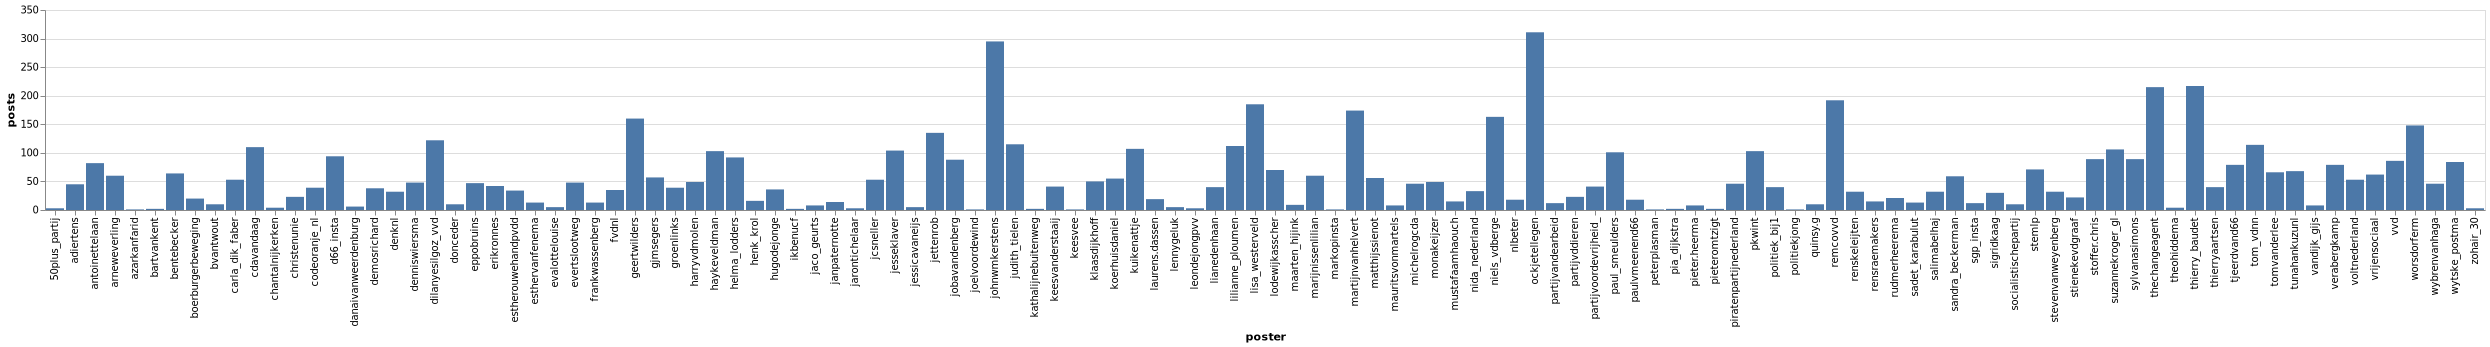

In [37]:
period_posts = combine(
    groupby(transform(posts, :post_created => ByRow(t -> round(t, Dates.Day)) => :period), [:poster_username, :period]),
    nrow => :num_posts)

sort!(period_posts, [:poster_username])

period_posts |> @vlplot(
    :bar,
    x={"poster_username:o", sort="x", axis={title="poster"}},
    y={"sum(num_posts)", axis={title="posts"}}
)